<a href="https://www.kaggle.com/code/sevdanuropur/a-b-anova-test?scriptVersionId=168550604" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A/B ANOVA TEST 

# Contents
* Dataset 
* What is Anova 
* Import Libraries
* Understand Data
* Outlier
* A/B Anova Testing
* With Outliers
* Result
* Conclusion

# Dataset 
A fast food chain wants to add three different promotions to its menu. However, they are undecided about which campaign they want to add as a promotion. These promotions were implemented in selected markets in various locations to see which promotion was more effective in sales.

* MarketID: unique identifier for market
* MarketSize: size of market area by sales
* LocationID: unique identifier for store location
* AgeOfStore: age of store in years
* Promotion: one of three promotions that were tested
* week: one of four weeks when the promotions were run
* SalesInThousands: sales amount for a specific LocationID, Promotion, and week

# What is Anova ?
ANOVA (Analysis of Variance) is a statistical method generally used to determine statistical differences between three or more groups. This method is used to evaluate whether the means between groups are statistically significantly different. ANOVA is based on comparing the variance between groups with the variance within the group. A test called the "F-test" is often used to evaluate the ratio of between-group variance to within-group variance. If this ratio shows a statistically significant difference, it is concluded that there is a significant difference between the groups. ANOVA is a commonly used method, especially to determine statistical differences between more than 2 groups.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessio

/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df_=pd.read_csv("/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv")

# Understand Data 

In [4]:
df=df_.copy()
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.7300
1,1,Medium,1,4,3,2,35.6700
2,1,Medium,1,4,3,3,29.0300
3,1,Medium,1,4,3,4,39.2500
4,1,Medium,2,5,2,1,27.8100


In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T) 

check_df(df)

##################### Shape #####################
(548, 7)
##################### Types #####################
MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object
##################### Head #####################
   MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1     Medium           1           4          3     1   
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0           33.7300  
1           35.6700  
2           29.0300  
3           39.2500  
4           27.8100  
##################### Tail #####################
     MarketID MarketSize  LocationID  AgeOfStore

Since we have examined the variables here, although some variables are categorical, when we look at their info, they appear as int. Let's first capture these variables and take a look at their distribution and unique values.

In [6]:
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

In [7]:
cat_cols=[col for col in df.columns if str(df[col].dtypes) in ["object","category","bool"]] 
num_but_cat = [col for col in df.columns if df[col].nunique() < 11 and df[col].dtypes in ["int", "float"]]
cat_but_car = [col for col in df.columns if df[col].nunique() > 20 and str(df[col].dtypes) in ["category", "object"]]
cat_cols = cat_cols + num_but_cat
cat_cols = [col for col in cat_cols if col not in cat_but_car]
cat_cols


['MarketSize', 'MarketID', 'Promotion', 'week']

In [8]:
num_col=[col for col in df.columns if df[col].dtypes in ["int64","float64"]]
num_col=[col for col in num_col if col not in cat_cols] 
num_col

['LocationID', 'AgeOfStore', 'SalesInThousands']

In [9]:
# lets look at percentage of categorical variables 
for col in cat_cols:
    print(pd.DataFrame({col:df[col].value_counts(),
                " Ratio": df[col].value_counts()/len(df)}))
    print("###########################################")


            MarketSize   Ratio
MarketSize                    
Medium             320  0.5839
Large              168  0.3066
Small               60  0.1095
###########################################
          MarketID   Ratio
MarketID                  
3               88  0.1606
10              80  0.1460
5               60  0.1095
6               60  0.1095
7               60  0.1095
1               52  0.0949
8               48  0.0876
9               40  0.0730
4               36  0.0657
2               24  0.0438
###########################################
           Promotion   Ratio
Promotion                   
3                188  0.3431
2                188  0.3431
1                172  0.3139
###########################################
      week   Ratio
week              
1      137  0.2500
2      137  0.2500
3      137  0.2500
4      137  0.2500
###########################################


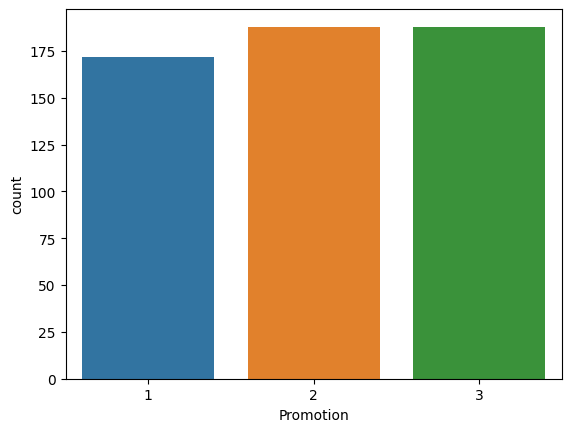

In [10]:
sns.countplot(x=df["Promotion"], data=df)
plt.show(block=True)

In [11]:
df.groupby("MarketID").agg({"Promotion":["count","nunique"]})

Promotion        
             count nunique
MarketID                  
1               52       3
2               24       2
3               88       3
4               36       3
5               60       3
6               60       3
7               60       3
8               48       3
9               40       3
10              80       3

In [12]:
df.groupby(["Promotion","MarketSize"]).agg({"LocationID":"count",
                                           "SalesInThousands":"mean"})

LocationID  SalesInThousands
Promotion MarketSize                              
1         Large               56           75.2359
          Medium              96           47.6726
          Small               20           60.1625
2         Large               64           60.3220
          Medium             108           39.1144
          Small               16           50.8106
3         Large               48           77.2040
          Medium             116           45.4689
          Small               24           59.5142

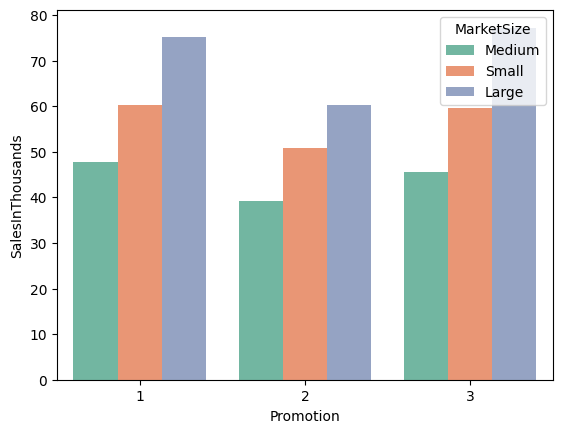

In [13]:
sns.barplot(data=df, x='Promotion', y='SalesInThousands', hue='MarketSize', ci=None, palette='Set2')
plt.show()

In [14]:
df.groupby(["Promotion","week"]).agg({"LocationID":"count",
                                           "SalesInThousands":"mean"})

LocationID  SalesInThousands
Promotion week                              
1         1             43           58.2444
          2             43           56.9295
          3             43           58.7749
          4             43           58.4472
2         1             47           47.7302
          2             47           47.5826
          3             47           47.7221
          4             47           46.2828
3         1             47           55.7762
          2             47           55.9491
          3             47           54.3779
          4             47           55.3547

In [15]:
# lets look at the relation between promotion and sales, it seems they are similat but we need to do A/b test 
df.groupby("Promotion").agg({"SalesInThousands":["mean","sum"]})

SalesInThousands           
                      mean        sum
Promotion                            
1                  58.0990  9993.0300
2                  47.3294  8897.9300
3                  55.3645 10408.5200

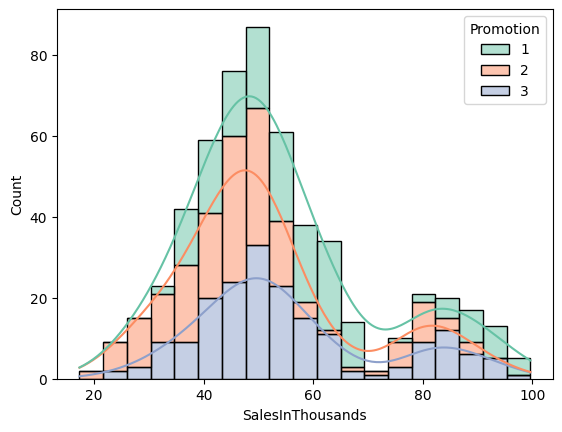

In [16]:
# lets draw a grapgh to see the relationship between promotion and SalesThpusands 
sns.histplot(data=df, x='SalesInThousands', hue='Promotion', multiple='stack', kde=True, palette='Set2')
plt.show(block=True)

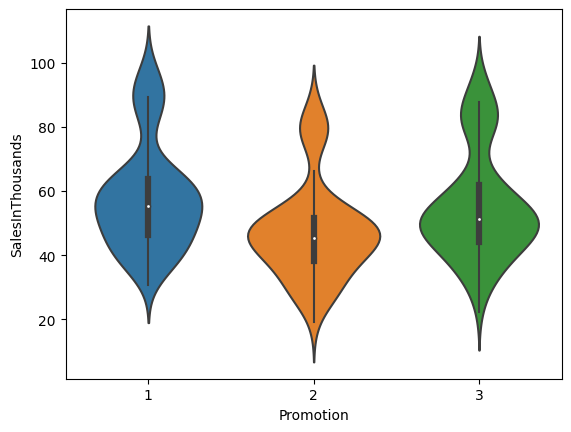

In [17]:
sns.violinplot(data=df, x='Promotion', y='SalesInThousands')
plt.show()

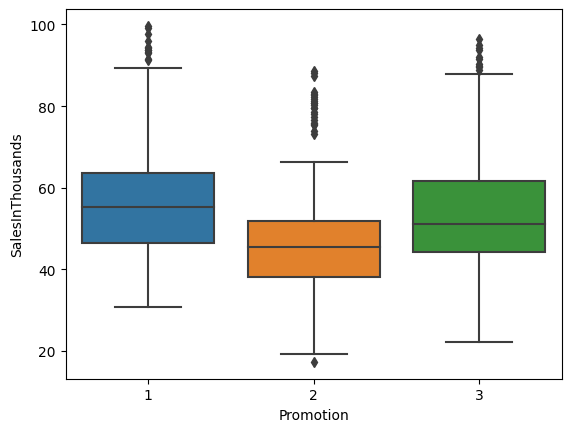

In [18]:
# Let's see if there are any outliers in the promotion types.
sns.boxplot(data=df, x='Promotion', y='SalesInThousands')
plt.show()

as we can see boxplot for each promotion type, there is an outlier for all of them, if we suppress this outliers we can interrept more correctly the result

# Outlier

In [19]:
# let determine the low_limit and up_limit for each promotion type 
def outlier_thresholds_try(dataframe, variable, promotion,promotion_type):
        new_df=dataframe[dataframe[promotion]==promotion_type]
        quartile1 = new_df[variable].quantile(0.25)
        quartile3 = new_df[variable].quantile(0.75)
        interquantile_range = quartile3 - quartile1
        up_limit = quartile3 + 1.5 * interquantile_range
        low_limit = quartile1 - 1.5 * interquantile_range
        return low_limit, up_limit

In [20]:
# lets look at first promotion type 
outlier_thresholds_try(df,"SalesInThousands","Promotion",1)

(20.455000000000016, 89.51499999999999)

In [21]:
# lets look at second promotion type 
outlier_thresholds_try(df,"SalesInThousands","Promotion",2)

(17.807500000000008, 72.10749999999999)

In [22]:
# and thrird one 
outlier_thresholds_try(df,"SalesInThousands","Promotion",3)

(17.89500000000001, 88.035)

In [23]:
# let's suppress the lower and upper limits of each promotion type

In [24]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(i, variable,)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [25]:
df_1=df[df["Promotion"]==1]
df_2=df[df["Promotion"]==2]
df_3=df[df["Promotion"]==3]
total_df=[df_1,df_2,df_3]

for i in total_df:
    replace_with_thresholds(i, "SalesInThousands")

In [26]:
df_new=pd.concat([df_1,df_2,df_3],ignore_index = True)

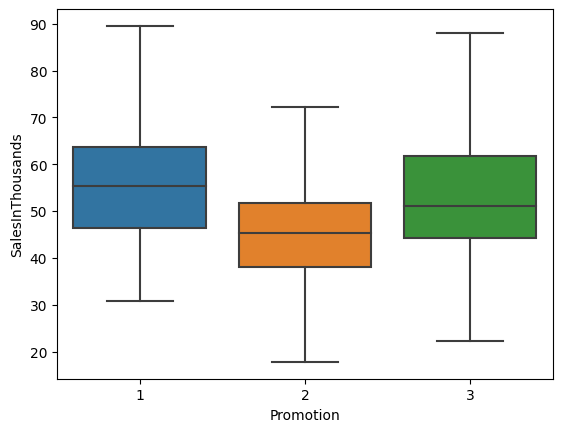

In [27]:
# as we can see here: we suppressed each promotion type with its own up and low values
sns.boxplot(data=df_new, x='Promotion', y='SalesInThousands')
plt.show()

# A/B Anova Testing

# Steps
1. first we will establish the hypothesis
1. H0: M1 = M2=M3 (no difference)
1. H1: M1 != M2 !=M3 ( there is a difference)
1. Then we will move on to the assumption checking phase.
1. If normality assumption + variance assumption is met, we can test with paramedric f_oneway
1. If the normality assumption is not met, we will directly apply the kruskal test (non-parametric test).

In [28]:
# 1. Establish Hypothesis:
# Is there a statistical difference between promotion types ?
# Ho: M1=M2 =M3 (no difference between them)
# H1= M1!=M2 != M3 (there is a difference between them)

In [29]:
# 1. Normality

# H0: Normal distribution assumption is met.
# H1:..not provided.

# HO RED if p-value < 0.05.
# If p-value is not < 0.05 H0 CANNOT BE REJECTED.

In [30]:
for group in list(df_new["Promotion"].unique()):
    pvalue = shapiro(df_new.loc[df["Promotion"] == group, "SalesInThousands"])[1]
    print(group, 'p-value: %.4f' % pvalue)

# we are gonna reject the H0 hypothesis because pvalues is less than 0.05 so There is no normal distribution

1 p-value: 0.0000
2 p-value: 0.0001
3 p-value: 0.0000


lets look at also levene test to look the Variance Homogeneous or not. Actually We don't need to look at the homogeneity of variance because the normality assumption is not met, we can directly move on to the non paramedric test part.

In [31]:
# H0: The assumption of variance homogeneity is satisfied.
# H1: The assumption of variance homogeneity is satisfied.
test_stat, pvalue = levene(df_new.loc[df_new["Promotion"] == 1, "SalesInThousands"],
                           df_new.loc[df_new["Promotion"] == 2, "SalesInThousands"],
                           df_new.loc[df_new["Promotion"] == 3, "SalesInThousands"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 3.2185, p-value = 0.0408


This means that the homogeneity assumption is not met because the p value is less than 0.05

In [32]:
# If the assumption is met, one way anova
# If the assumption is not met, we will look at kruskal: non-paramedric

In [33]:
# Lets apply the non-paramedrik anova test 
print(kruskal(df_new.loc[df_new["Promotion"] == 1, "SalesInThousands"],
                     df_new.loc[df["Promotion"] == 2, "SalesInThousands"],
                     df_new.loc[df["Promotion"] == 3, "SalesInThousands"])[1])

0.00045269238355847636


The p value is less than 0.05. This means that we can reject the H0 hypothesis and This suggests that there are statistically significant differences between the promotion types.

In [34]:
# Let's compare pairwise means with Tukey tests to see the difference between them
from statsmodels.stats.multicomp import MultiComparison
comparison = MultiComparison(df_new['SalesInThousands'], df['Promotion'])
tukey = comparison.tukeyhsd(0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -2.3818 0.3266 -6.2986 1.5351  False
     1      3  -1.2048   0.75 -5.1216 2.7121  False
     2      3    1.177 0.7503 -2.6519 5.0058  False
---------------------------------------------------


## With Outliers 

In [35]:
df=df_.copy()

In [36]:
for group in list(df["Promotion"].unique()):
    pvalue = shapiro(df.loc[df["Promotion"] == group, "SalesInThousands"])[1]
    print(group, 'p-value: %.4f' % pvalue)
#still, they are less than 0.5 , we are rejecting the H0 , there is no normal varsayım

3 p-value: 0.0000
2 p-value: 0.0000
1 p-value: 0.0000


In [37]:
# lets apply non-paramedrik test

print(kruskal(df.loc[df["Promotion"] == 1, "SalesInThousands"],
                     df.loc[df["Promotion"] == 2, "SalesInThousands"],
                     df.loc[df["Promotion"] == 3, "SalesInThousands"])[1])

2.6741866266697816e-12


According to this result, we reject h0 because it is less than the p value and say that there is a statistical difference between promotion types.

# Result 
In this study, I also compared the tests with and without outliers. I have observed that there is a slight difference in the resulting values. As we can see from this, the way we receive the data can affect the results. But as a result, we saw that there is a difference between the promotion types by rejecting H0, as seen in both of them.

# Conclusion 

Hello again! It was really enjoyable for me to complete this work. I tried to concretize my analyzes on A/B  Anova testing with this fast food data set. If you liked the work I did on this subject, I am waiting for your comments. If you have any bugs or improvement suggestions, please share. Also, if you have suggestions or topics you would like to include in my future projects, let me know. I look forward to your contributions and thank you! 🚀📈